# Neural Style Transfer

## Summary

- Introduction
- Example: a starry night in Paris

## Introduction

### Neural Style Transfer in a nutshell

- Reproduce an image with a new artistic style provided by another image.
- Blend a *content* image and a *style reference* image in a stylized output image.
- First described in [A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576) by Gatys et al (2015). Many refinements and variations since.

### Example

[![Prisma style transfer example](images/style_transfer_prisma.png)](https://harishnarayanan.org/writing/artistic-style-transfer/)

### Underlying idea: loss minimization

The resulting image $x^*$ minimizes a weighted sum of two losses: content loss $\mathcal{L}_{content}(c, x)$ and style loss $\mathcal{L}_{style}(s, x)$.

$$x^* = \underset{x}{\mathrm{argmin}}(\alpha\mathcal{L}_{content}(c, x) + \beta\mathcal{L}_{style}(s, x))$$

- $x$: generated image.
- $c$: content image.
- $s$: reference style image.

### The content loss

- Content = high-level structure of an image.
- Can be captured by the upper layer of a convolutional neural network.
- Content loss for a layer = distance between the feature maps of the content and generated images.

### The style loss

- Style = low-level features of an image (textures, colors, visual patterns).
- Can be captured by using correlations across the different feature maps (filter responses) of a convnet.
- Feature correlations are computed via a Gram matrix (outer product of the feature maps for a given layer).
- Style loss for a layer = distance between the Gram matrices of the feature maps for the style and generated images.

### The total variation loss

- Sum of the absolute differences for neighboring pixel-values in an image. Measures how much noise is in the image.
- Encourage spatial continuity in the generated image (denoising).
- Act as a regularization loss.

### Gradient descent

- Objective: minimize the total loss.
- Optimizer: [L-BFGS](http://aria42.com/blog/2014/12/understanding-lbfgs) (original choice made by Gatys et al.) or Adam.

![Animation of style transfer](images/style_transfer_animated.gif)

## Example: a starry day in Paris

(Heavily inspired by [this Keras example](https://keras.io/examples/generative/neural_style_transfer/))

### Environment setup

In [1]:
import platform

print(f"Python version: {platform.python_version()}")
assert platform.python_version_tuple() >= ("3", "6")

from IPython.display import Image, display

import numpy as np

Python version: 3.8.5


In [2]:
import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tf.keras.__version__}")
print('GPU found :)' if tf.config.list_physical_devices("GPU") else 'No GPU :(')

from tensorflow.keras import Model
from tensorflow.keras.applications import vgg19
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.schedules import ExponentialDecay

TensorFlow version: 2.2.0
Keras version: 2.3.0-tf
GPU found :)


### Images loading

In [3]:
# Download content and style images
base_image_path = get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_image_path = get_file(
    "starry_night.jpg", "https://i.imgur.com/9ooB60I.jpg"
)

width, height = load_img(base_image_path).size
print(f"Input image dimensions: {width, height}")

Input image dimensions: (910, 607)


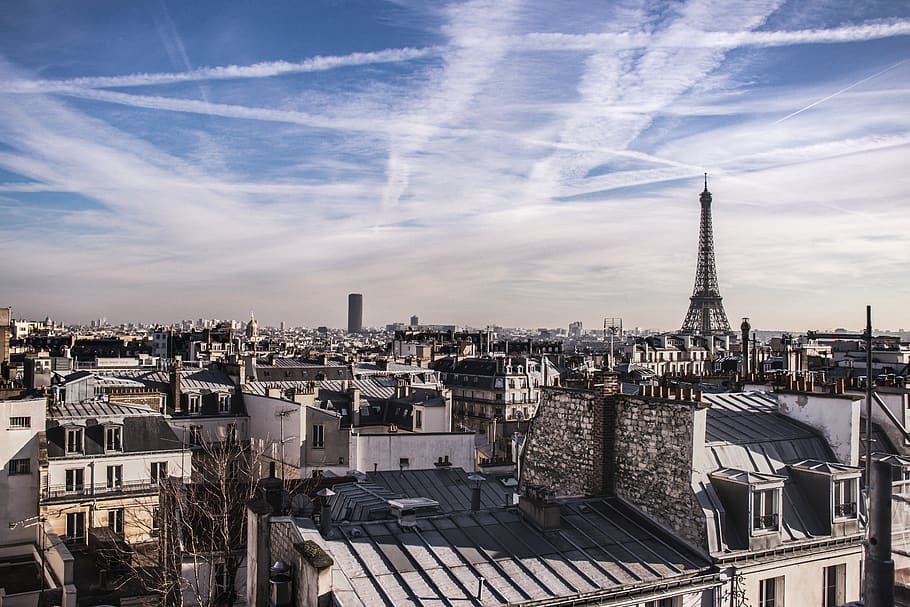

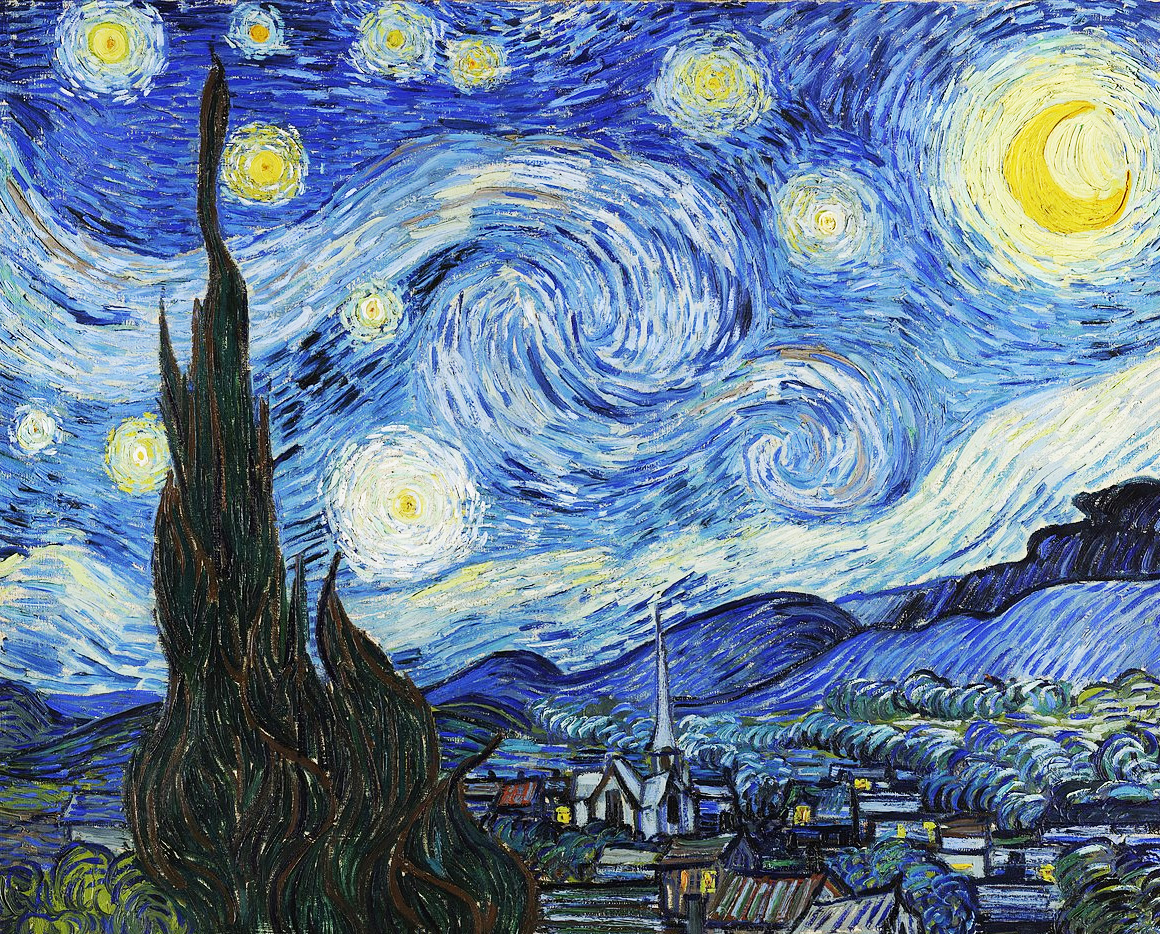

In [4]:
# Show content and style images
display(Image(base_image_path))
display(Image(style_reference_image_path))

In [5]:
def preprocess_image(image_path, height, width):
    """Open, resize and format a picture into appropriate tensors"""
    img = load_img(
        image_path, target_size=(height, width)
    )
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    # Convert image from RGB to BGR and zero-center each color channel w.r.t. the ImageNet dataset
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)


def deprocess_image(x, height, width):
    """Convert a tensor into a valid image"""
    x = x.reshape((height, width, 3))
    # Remove zero-center by mean pixel applied by vgg19.preprocess_input()
    # The following values are the mean pixel values of each color channel for the ImageNet dataset
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [6]:
# The gram matrix of an image tensor (feature-wise outer product)
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram


# The style loss is designed to maintain the style of the reference image in the generated image
# It is based on the gram matrices (which capture style) of feature maps from the style reference image
# and from the generated image
def style_loss(style, combination, height, width):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [7]:
# The content loss is designed to maintain the "content" of the base image in the generated image
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

# The total variation loss is designed to keep the generated image locally coherent
def total_variation_loss(x, height, width):
    a = tf.square(
        x[:, : height - 1, : width - 1, :] - x[:, 1:, : width - 1, :]
    )
    b = tf.square(
        x[:, : height - 1, : width - 1, :] - x[:, : height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [8]:
# Build a VGG19 model loaded with pre-trained ImageNet weights
vgg = vgg19.VGG19(weights="imagenet", include_top=False)

# Get the symbolic outputs of each "key" layer (we gave them unique names)
outputs_dict = dict([(layer.name, layer.output) for layer in vgg.layers])

# Set up a model that returns the activation values for every layer in VGG19 (as a dict)
feature_extractor = Model(inputs=vgg.inputs, outputs=outputs_dict)


In [9]:
# List of layers to use for the style loss
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
# The layer to use for the content loss
content_layer_name = "block5_conv2"

# Weights of the different loss components
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image, height, width):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)

    # Initialize the loss
    loss = tf.zeros(shape=())

    # Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    # Add style loss
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features, height, width)
        loss += (style_weight / len(style_layer_names)) * sl

    # Add total variation loss
    loss += total_variation_weight * total_variation_loss(combination_image, height, width)
    return loss

In [10]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image, height, width):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image, height, width)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

In [11]:
# Generated image height
gen_height = 400
# Compute generated width so that input and generated images have same scale
gen_width = int(width * gen_height / height)
print(f"Generated image dimensions: {gen_width, gen_height}")

Generated image dimensions: (599, 400)


In [13]:
optimizer = SGD(
    ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path, gen_height, gen_width)
style_reference_image = preprocess_image(style_reference_image_path, gen_height, gen_width)
combination_image = tf.Variable(preprocess_image(base_image_path, gen_height, gen_width))

result_image_prefix = "paris_generated"
n_epochs = 1000
for epoch in range(1, n_epochs + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image, gen_height, gen_width
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if epoch % 100 == 0:
        print(f"Epoch [{epoch}/{n_epochs}], loss: {loss:.2f}")
        img = deprocess_image(combination_image.numpy(), gen_height, gen_width)
        fname = result_image_prefix + f"_at_iteration_{epoch}.png"
        save_img(fname, img)

Epoch [100/1000], loss: 11018.34
Epoch [200/1000], loss: 8514.22
Epoch [300/1000], loss: 7571.62
Epoch [400/1000], loss: 7064.01
Epoch [500/1000], loss: 6736.22
Epoch [600/1000], loss: 6501.81
Epoch [700/1000], loss: 6323.29
Epoch [800/1000], loss: 6181.49
Epoch [900/1000], loss: 6065.40
Epoch [1000/1000], loss: 5967.84


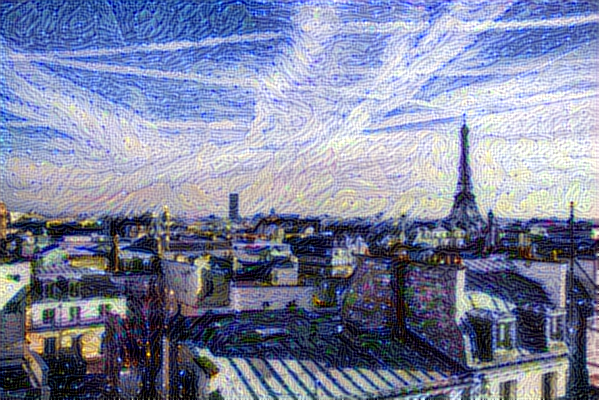

In [14]:
# Show final generated image
display(Image(result_image_prefix + "_at_iteration_" + str(n_epochs) + ".png"))